In [1]:
import datetime
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import KernelPCA
import numpy as np
import pandas as pd
import math
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
tf.random.set_seed(99)
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

In [2]:
# Dataset loading
# dataFrame = pd.read_csv('final_data_adj.csv') # https://github.com/SusmitSekharBhakta/Stock-market-price-prediction/blob/main/final_data_adj.csv

# ИТП дс171
df_filter = pd.read_csv('DC171_2021-2022_5min.csv', # путь к файлу, (используй автодотолнение)
                   sep=',', # разделитель данных в файле
                 
                   #  header= {None|Целочисленное} номер строки с заголовками, нумерация с нуля
                   header=0,       #если заголовки в нулевой строке таблицы
                   #  header=None  #если заголовки отсутствуют

    
) 

# colNamesList_fil = ['timestamp','Температура наружного воздуха', 'Температура прямой сетевой воды', 'Температура обратной сетевой воды', 'Рассчитанная температура смеси на отопление', 'Рассчитанная температура обратной смеси', 'Delta']

# df_filter.columns = (colNamesList_fil)
# df_85.columns = (colNamesList)
# df_filter
dataFrame = df_filter
dataFrame

,timestamp,Tsup,Tback,SP_sup,SP_back
0,2021-10-05 13:50:00,45.066909,44.029060,48.080080,40.477175
1,2021-10-05 13:55:00,47.172201,43.836367,48.064882,40.459339
2,2021-10-05 14:00:00,50.358132,43.263756,48.021463,40.409188
3,2021-10-05 14:05:00,45.490079,44.087679,47.971722,40.351585
4,2021-10-05 14:10:00,49.877687,43.233314,47.905637,40.275738
...,...,...,...,...,...
54450,2022-04-27 08:15:00,52.934261,43.523993,48.993921,41.531379
54451,2022-04-27 08:20:00,45.670143,44.153303,48.976375,41.511059
54452,2022-04-27 08:25:00,52.406526,43.776804,48.976953,41.511774
54453,2022-04-27 08:30:00,45.403079,43.968268,48.965460,41.498325


In [3]:
dataFrame['timestamp'] = pd.to_datetime(dataFrame['timestamp'])
dataFrame = dataFrame.set_index('timestamp')

In [4]:
# dataFrame['Delta'] = dataFrame['Tsup'] - dataFrame['Tback']
dataFrame.loc[:, 'hour'] = dataFrame.index.hour
dataFrame.loc[:, 'day_of_week'] = dataFrame.index.weekday
dataFrame.loc[:, 'day_of_year'] = dataFrame.index.dayofyear

# Минимаксная нормализация
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(dataFrame)
data_normalized = pd.DataFrame(data_normalized, columns=list(dataFrame.columns))

# Стандартизация
scaler = StandardScaler()
data_standardized = scaler.fit_transform(dataFrame)
data_standardized = pd.DataFrame(data_standardized, columns=list(dataFrame.columns))

# Масштабирование по медиане и IQR
scaler = RobustScaler()
data_robust_scaled = scaler.fit_transform(dataFrame)
data_robust_scaled = pd.DataFrame(data_robust_scaled, columns=list(dataFrame.columns))


print(data_normalized)
print(data_standardized)
print(data_robust_scaled)

           Tsup     Tback    SP_sup   SP_back      hour  day_of_week  \
0      0.402893  0.523380  0.245408  0.308152  0.565217     0.166667   
1      0.440970  0.518617  0.244997  0.307628  0.565217     0.166667   
2      0.498591  0.504465  0.243823  0.306153  0.608696     0.166667   
3      0.410547  0.524829  0.242479  0.304458  0.608696     0.166667   
4      0.489902  0.503712  0.240693  0.302228  0.608696     0.166667   
...         ...       ...       ...       ...       ...          ...   
54450  0.545183  0.510897  0.270106  0.339158  0.347826     0.333333   
54451  0.413804  0.526451  0.269632  0.338561  0.347826     0.333333   
54452  0.535639  0.517145  0.269647  0.338582  0.347826     0.333333   
54453  0.408973  0.521877  0.269337  0.338186  0.347826     0.333333   
54454  0.527207  0.515280  0.268317  0.336902  0.347826     0.333333   

       day_of_year  
0         0.760989  
1         0.760989  
2         0.760989  
3         0.760989  
4         0.760989  
...      

In [5]:
def singleStepSamplerOptimized(df, window):
    n_samples = len(df) - window
    n_features = df.shape[1]
    xRes = np.zeros((n_samples, window, n_features))
    yRes = np.zeros((n_samples, 4))  # Предполагаем, что у вас 5 целевых колонок

    for i in range(n_samples):
        xRes[i] = df.iloc[i:i+window].values
        yRes[i] = df[['Tback', 'Tsup', 'SP_back', 'SP_sup']].iloc[i + window].values

    return xRes, yRes


from concurrent.futures import ThreadPoolExecutor

def process_sample(i, df, window):
    x_sample = df.iloc[i:i+window].values
    y_sample = df[['Tback', 'Tsup', 'SP_back', 'SP_sup']].iloc[i + window].values
    return x_sample, y_sample

def singleStepSamplerParallel(df, window):
    n_samples = len(df) - window
    results = []
    
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_sample, i, df, window) for i in range(n_samples)]
        results = [f.result() for f in futures]

    xRes, yRes = zip(*results)
    return np.array(xRes), np.array(yRes)



In [6]:
# data_array = data_normalized.values
seq_length = 12

In [7]:
# X, y = singleStepSampler(data_normalized, seq_length)
# X, y = singleStepSampler2(data_normalized, seq_length)
X, y = singleStepSamplerOptimized(data_standardized, seq_length)
#X, y = singleStepSamplerParallel(data_normalized, seq_length)

In [8]:
X.shape

(54443, 12, 7)

In [9]:
y.shape

(54443, 4)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
X_train.shape

(43554, 12, 7)

In [12]:
X_test.shape

(10889, 12, 7)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(100, activation='sigmoid',input_shape=(X_train.shape[1], X_train.shape[2])))  # 50 нейронов в LSTM слое
model.add(keras.layers.Dropout(0.2))
model.add(Dense(4))

model.compile(loss = 'mse', metrics=['mse'], optimizer='adam')
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,604 (170.33 KB)

 Trainable params: 43,604 (170.33 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history=model.fit(X_train, y_train, epochs=50,
validation_data=(X_test, y_test))

Epoch 1/50
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2024 - val_loss: 0.0345
Epoch 2/50
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0469 - val_loss: 0.0229
Epoch 3/50
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0329 - val_loss: 0.0159
Epoch 4/50
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0268 - val_loss: 0.0146
Epoch 5/50
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0252 - val_loss: 0.0144
Epoch 6/50
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0239 - val_loss: 0.0139
Epoch 7/50
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0230 - val_loss: 0.0139
Epoch 8/50
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0226 - val_loss: 0.0129
Epoch 9/50
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0218 - val_loss: 0.0126
Epoch 10/50
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0217 - val_loss: 0.0125
Epoch 11/50
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0212 - val_loss: 0.0116
Epoch 12/50
1362/1362 ━━━━━━━━

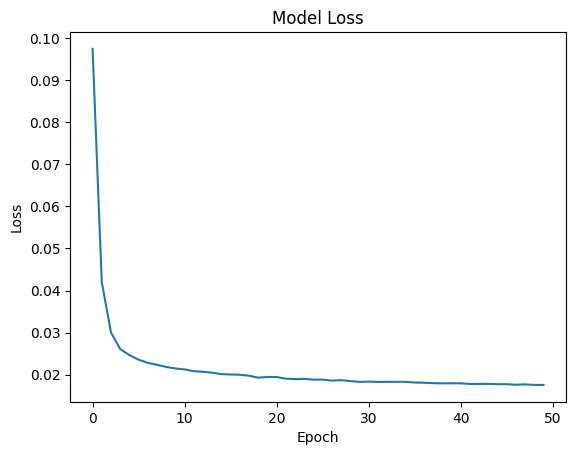

In [15]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [16]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

from sklearn.metrics import r2_score
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('R-squared:', r2)

Train Score: 0.01 MSE (0.10 RMSE)
Test Score: 0.01 MSE (0.10 RMSE)
341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
R-squared: 0.9907432507862619


In [17]:
## Прогнозирование за другой период на том же объекте

In [18]:
import tensorflow as tf
import numpy as np
import requests
import json
from sklearn.model_selection import train_test_split
import pandas as pd

# Функция для загрузки данных с сервера
def load_data(tag_ids, start_time, end_time):
    values_all = []
    for tag_id in tag_ids:
        url = f"http://tes.cloud.nstu.ru/proxy/tags/GetTagValues?tagId={tag_id}&startTime={start_time}&endTime={end_time}"
        response = requests.get(url)
        data = json.loads(response.text)
        values = np.array([entry['value'] for entry in data])
        values_all.append(values)
    timestamps = np.array([entry['timestamp'] for entry in data])
    return np.array(values_all), timestamps

In [19]:
# Загрузка данных за 2021-2022 год
tag_ids = [30,31,32,33]
start_time = "2022-10-01"
end_time = "2023-05-01"
values, timestamps = load_data(tag_ids, start_time, end_time)

# Преобразование в DataFrame
data = pd.DataFrame(data={'timestamp': timestamps,
                          'Tsup': values[0],
                          'Tback': values[1],
                          'SP_sup': values[2],
                          'SP_back': values[3]
                          })

# Преобразуем столбец timestamp в формат datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Устанавливаем timestamp как индекс DataFrame
data = data.set_index('timestamp')

# Удаление строк со значениями 0 или аномальными значениями
data = data[(data['Tsup'] !=  0) & (data['Tback'] !=  0) & (data['SP_sup'] !=  0) & (data['SP_back'] !=  0)]

# Ресэмплируем данные с периодичностью 5/10 минут
data_to_model2 = data.resample('5T').mean()

data_to_model2 = data_to_model2.dropna()

/var/folders/4b/qt61zsy57dddqwgkrbwk3m380000gq/T/ipykernel_77303/699693162.py:25: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data_to_model2 = data.resample('5T').mean()


In [20]:
# Извлечь номер часа, дня недели и дня в месяце из индекса и добавить его как столбец

data_to_model2.loc[:, 'hour'] = data_to_model2.index.hour
data_to_model2.loc[:, 'day_of_week'] = data_to_model2.index.weekday
data_to_model2.loc[:, 'day_of_year'] = data_to_model2.index.dayofyear


# Стандартизация
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data_to_model2)
data_standardized = pd.DataFrame(data_standardized, columns=list(data_to_model2.columns))

# data_to_model2 = data_standardized

In [21]:
# data_to_model2 = data_standardized
data_standardized

,Tsup,Tback,SP_sup,SP_back,hour,day_of_week,day_of_year
0,-0.979003,-1.627928,-1.473581,-1.686011,0.341967,-1.549800,0.904129
1,-1.803794,-1.522706,-1.476950,-1.690580,0.341967,-1.549800,0.904129
2,-1.199900,-1.589126,-1.477676,-1.691511,0.341967,-1.549800,0.904129
3,-1.668648,-1.520491,-1.474254,-1.686868,0.341967,-1.549800,0.904129
4,-1.654948,-1.544556,-1.469594,-1.680540,0.341967,-1.549800,0.904129
...,...,...,...,...,...,...,...
46440,-1.113152,-0.770687,-0.828752,-0.810901,1.643716,1.534592,-0.342374
46441,-0.403584,-0.915748,-0.825681,-0.806733,1.643716,1.534592,-0.342374
46442,-1.205755,-0.773839,-0.823758,-0.804115,1.643716,1.534592,-0.342374
46443,-0.525853,-0.846279,-0.821380,-0.800896,1.643716,1.534592,-0.342374


In [22]:
new_X, new_y = singleStepSamplerOptimized(data_standardized, seq_length)
# new_X = new_X.reshape((new_X.shape[0], new_X.shape[1], 1))

In [23]:
new_predictions = model.predict(new_X)

1452/1452 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(new_y, new_predictions)
mae = mean_absolute_error(new_y, new_predictions)
r2 = r2_score(new_y, new_predictions)

# print('R-squared:', r2)
print(f"MSE: {mse}, MAE: {mae}, R2: {r2}")

MSE: 0.05444459068567417, MAE: 0.09716219890934426, R2: 0.9455380338018629


In [25]:
new_y

array([[-1.58254372, -1.31818032, -1.62763329, -1.43058207],
       [-1.5000605 , -1.44725318, -1.6232055 , -1.42731616],
       [-1.5523059 , -1.4842137 , -1.61828222, -1.42370948],
       ...,
       [-0.77383904, -1.20575478, -0.80411504, -0.82375809],
       [-0.84627938, -0.52585275, -0.80089563, -0.82137971],
       [-0.7111253 , -1.01428247, -0.79633032, -0.8180163 ]])

In [26]:
new_predictions

array([[-1.5244315 , -1.2957174 , -1.6033708 , -1.4048631 ],
       [-1.517264  , -1.4685267 , -1.6022526 , -1.4048433 ],
       [-1.4847941 , -1.4052714 , -1.5884871 , -1.3939874 ],
       ...,
       [-0.8025253 , -1.1008217 , -0.80214846, -0.7985678 ],
       [-0.80691135, -0.4409661 , -0.7763286 , -0.7678883 ],
       [-0.8038758 , -0.9354957 , -0.7835955 , -0.7824906 ]],
      dtype=float32)

In [27]:
print("Shape of data_to_model2:", data_to_model2.shape)
print("Shape of new_predictions:", new_predictions.shape)

Shape of data_to_model2: (46445, 7)
Shape of new_predictions: (46433, 4)


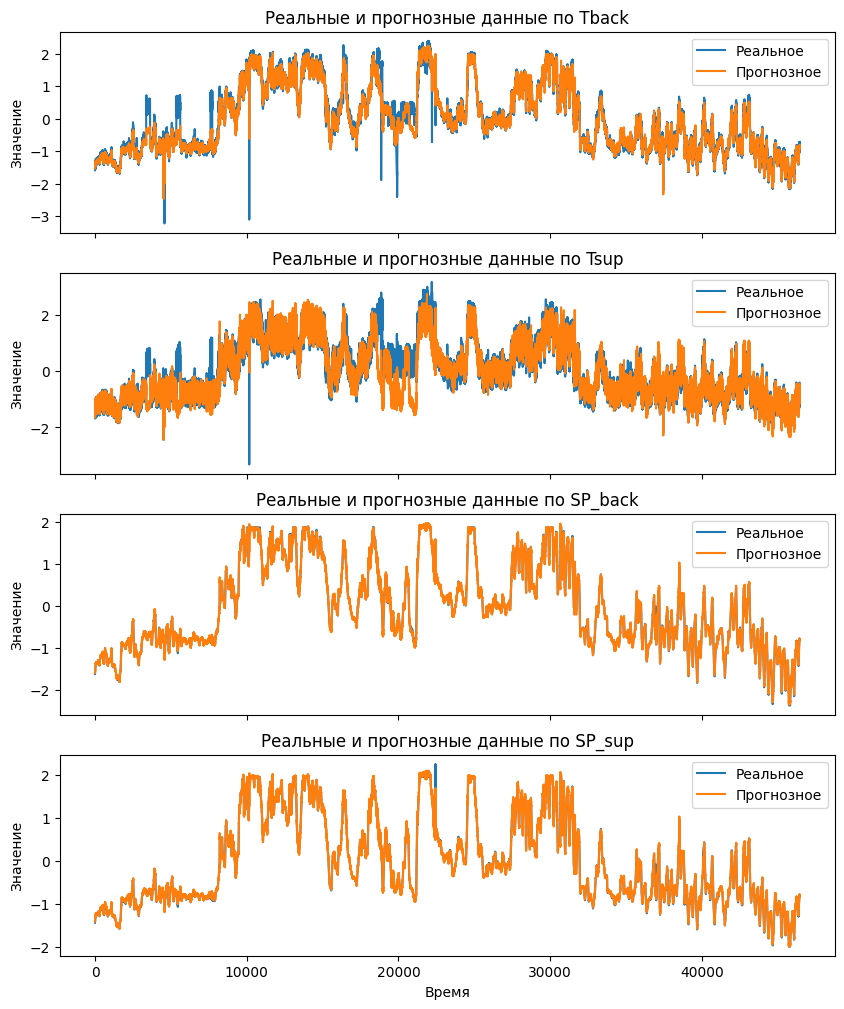

In [28]:


fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

for i in range(4):
    axs[i].plot(new_y[:, i], label='Реальное')
    axs[i].plot(new_predictions[:, i], label='Прогнозное')
    if( i == 0 ): { axs[i].set_title(f'Реальные и прогнозные данные по Tback') }
    if( i == 1 ): { axs[i].set_title(f'Реальные и прогнозные данные по Tsup') }
    if( i == 2 ): {axs[i].set_title(f'Реальные и прогнозные данные по SP_back') }
    if( i == 3 ): {axs[i].set_title(f'Реальные и прогнозные данные по SP_sup') }
    axs[i].set_ylabel('Значение')
    axs[i].legend()

plt.xlabel('Время')
plt.show()

In [29]:
import plotly.graph_objects as go
from plotly.offline import plot

# Создание фигуры
fig3 = go.Figure()

# Добавление графиков для каждого из пяти признаков
titles = ['Tback', 'Tsup', 'SP_back', 'SP_sup']
for i in range(4):
    fig3.add_trace(go.Scatter(
        x=list(range(len(new_y[:, i]))), 
        y=new_y[:, i], 
        mode='lines',
        name=f'Реальное {titles[i]}'
    ))
    fig3.add_trace(go.Scatter(
        x=list(range(len(new_predictions[:, i]))), 
        y=new_predictions[:, i], 
        mode='lines',
        name=f'Прогнозное {titles[i]}'
    ))

    # Настройка макета для каждого отдельного графика
    fig3.update_layout(
        title=f'Реальные и прогнозные данные по {titles[i]}',
        xaxis_title='Время',
        yaxis_title='Значение',
        legend_title='Легенда',
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )

# Сохранение фигуры и открытие в новой вкладке браузера
plot(fig3)


'temp-plot.html'

In [30]:
# По другому объекту

In [31]:
# ИТП шк85
tag_ids = [44,45,46,47]
start_time = "2021-10-01"
end_time = "2022-05-01"
values, timestamps = load_data(tag_ids, start_time, end_time)

# Преобразование в DataFrame
data = pd.DataFrame(data={'timestamp': timestamps,
                          'Tsup': values[0],
                          'Tback': values[1],
                          'SP_sup': values[2],
                          'SP_back': values[3]
                          })

# Преобразуем столбец timestamp в формат datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Устанавливаем timestamp как индекс DataFrame
data = data.set_index('timestamp')

# Удаление строк со значениями 0 или аномальными значениями
data = data[(data['Tsup'] !=  0) & (data['Tback'] !=  0) & (data['SP_sup'] !=  0) & (data['SP_back'] !=  0)]

# Ресэмплируем данные с периодичностью 5/10 минут
data_to_model3 = data.resample('5T').mean()

data_to_model3 = data_to_model3.dropna()

/var/folders/4b/qt61zsy57dddqwgkrbwk3m380000gq/T/ipykernel_77303/4260422391.py:25: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.



In [32]:
# Извлечь номер часа, дня недели и дня в месяце из индекса и добавить его как столбец

data_to_model3.loc[:, 'hour'] = data_to_model3.index.hour
data_to_model3.loc[:, 'day_of_week'] = data_to_model3.index.weekday
data_to_model3.loc[:, 'day_of_year'] = data_to_model3.index.dayofyear

scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data_to_model3)
data_normalized = pd.DataFrame(data_normalized, columns=list(data_to_model3.columns))

# Стандартизация
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data_to_model3)
data_standardized = pd.DataFrame(data_standardized, columns=list(data_to_model3.columns))

# data_to_model2 = data_standardized

In [33]:
new_X, new_y = singleStepSamplerOptimized(data_standardized, seq_length)

In [34]:
new_predictions = model.predict(new_X)

1399/1399 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(new_y, new_predictions)
mae = mean_absolute_error(new_y, new_predictions)
r2 = r2_score(new_y, new_predictions)
# print('R-squared:', r2)
print(f"MSE: {mse}, MAE: {mae}, R2: {r2}")

MSE: 0.09006587650232765, MAE: 0.2003684696933585, R2: 0.9099377264166972


In [36]:
import plotly.graph_objects as go
from plotly.offline import plot

# Создание фигуры
fig4 = go.Figure()

# Добавление графиков для каждого из пяти признаков
titles = ['Tback', 'Tsup', 'SP_back', 'SP_sup']
for i in range(4):
    fig4.add_trace(go.Scatter(
        x=list(range(len(new_y[:, i]))), 
        y=new_y[:, i], 
        mode='lines',
        name=f'Реальное {titles[i]}'
    ))
    fig4.add_trace(go.Scatter(
        x=list(range(len(new_predictions[:, i]))), 
        y=new_predictions[:, i], 
        mode='lines',
        name=f'Прогнозное {titles[i]}'
    ))

    # Настройка макета для каждого отдельного графика
    fig4.update_layout(
        title=f'Реальные и прогнозные данные по {titles[i]}',
        xaxis_title='Время',
        yaxis_title='Значение',
        legend_title='Легенда',
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )


# Сохранение фигуры и открытие в новой вкладке браузера
plot(fig4)


'temp-plot.html'